In [1]:
import sys
import pandas as pd
import numpy as np
import requests
from doctest import testmod as run_doctests

sys.tracebacklimit = 0

In [2]:
CONFIRMED = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
DEATHS = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
RECOVERED = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'

confirmed = pd.read_csv(CONFIRMED)
deaths = pd.read_csv(DEATHS)
recovered = pd.read_csv(RECOVERED)

In [6]:
%%timeit -r 1 -n 1
confirmed = pd.read_csv(CONFIRMED)

644 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [3]:
confirmed

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,12/13/21,12/14/21,12/15/21,12/16/21,12/17/21,12/18/21,12/19/21,12/20/21,12/21/21,12/22/21
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,157648,157660,157665,157725,157734,157745,157787,157797,157816,157841
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,203925,204301,204627,204928,205224,205549,205777,205897,206273,206616
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,213058,213288,213533,213745,214044,214330,214592,214835,215145,215430
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,19440,20136,20136,20549,20549,20549,20549,21062,21062,21372
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,65404,65431,65565,65648,65760,65868,65938,66086,66566,67199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,NaN,Vietnam,14.058324,108.277199,0,2,2,2,2,2,...,1428428,1443648,1459175,1493237,1508473,1524368,1540478,1555455,1571780,1588335
276,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,464341,464751,465094,465094,465094,465094,465094,466669,467058,467391
277,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,10072,10075,10081,10086,10092,10097,10101,10102,10103,10103
278,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,...,211234,211705,212278,213139,214433,215472,216508,217117,219023,221880


In [7]:
confirmed.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Columns: 705 entries, Province/State to 12/22/21
dtypes: float64(2), int64(701), object(2)
memory usage: 1.5 MB


In [8]:
confirmed.columns

Index(['Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       ...
       '12/13/21', '12/14/21', '12/15/21', '12/16/21', '12/17/21', '12/18/21',
       '12/19/21', '12/20/21', '12/21/21', '12/22/21'],
      dtype='object', length=705)

In [9]:
confirmed.index

RangeIndex(start=0, stop=280, step=1)

In [15]:
poland = confirmed['Country/Region'] == 'Poland'
pl = confirmed[poland].transpose()[4:]
pl.columns = ['Confirmed']
pl.index = pl.index.map(pd.to_datetime)

In [25]:
pl.last('W')

,Confirmed
2021-12-20,3968450
2021-12-21,3982257
2021-12-22,4000270


In [30]:
pl.loc['2021-12-10':'2021-12-23']

,Confirmed
2021-12-10,3785036
2021-12-11,3808798
2021-12-12,3828248
2021-12-13,3839625
2021-12-14,3857085
2021-12-15,3881349
2021-12-16,3903445
2021-12-17,3923472
2021-12-18,3942864
2021-12-19,3958840


In [128]:
def _get(data, name, country):
    """
    >>> _get(confirmed, 'Confirmed', 'Poland').loc['2021-11-11']
    Confirmed    3162804
    Name: 2021-11-11 00:00:00, dtype: int64
    
    >>> _get(confirmed, 'Confirmed', 'US').loc['2021-11-11']
    Confirmed    46868214
    Name: 2021-11-11 00:00:00, dtype: int64
    """
    q = data['Country/Region'] == country
    result = data[q].transpose()[4:].sum(axis='columns').astype(int)
    df = pd.DataFrame(result)
    df.columns = [name]
    df.index = df.index.map(pd.to_datetime)
    return df


def covid(country):
    """
    >>> poland.loc['2021-11-11']
    Confirmed    3162804
    Deaths         78524
    Recovered          0
    Name: 2021-11-11 00:00:00, dtype: int64
    
    >>> usa.loc['2021-11-11']
    Confirmed    46868214
    Deaths         761002
    Recovered           0
    Name: 2021-11-11 00:00:00, dtype: int64
    """
    return pd.concat((
        _get(confirmed, 'Confirmed', country),
        _get(deaths, 'Deaths', country),
        _get(recovered, 'Recovered', country),
    ), axis='columns')
    

run_doctests()

TestResults(failed=0, attempted=4)

In [116]:
poland = covid('Poland')
germany = covid('Germany')
usa = covid('US')
france = covid('France')

<AxesSubplot:>

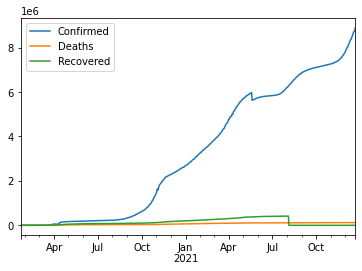

In [118]:
france.plot()

<AxesSubplot:>

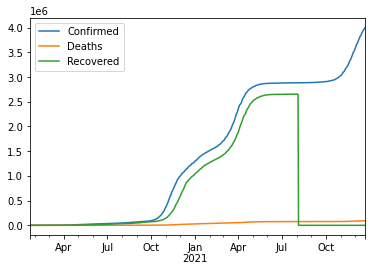

In [119]:
poland.plot()

<AxesSubplot:>

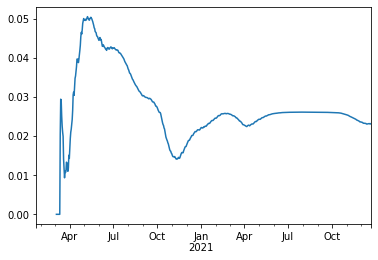

In [123]:
(poland['Deaths'] / poland['Confirmed']).plot()

<AxesSubplot:>

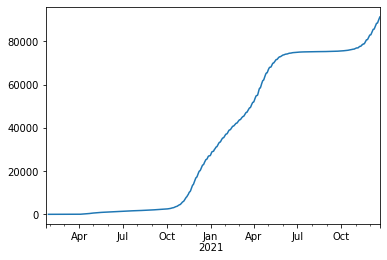

In [125]:
poland['Deaths'].rolling(window=7).median().plot()

<AxesSubplot:>

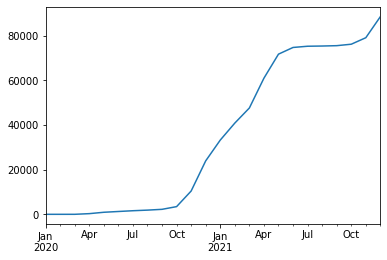

In [126]:
poland['Deaths'].resample('M').median().plot()

In [133]:
compare_confirmed = pd.concat((poland['Confirmed'], germany['Confirmed']), axis='columns')
compare_confirmed.columns = ['Poland', 'Germany']

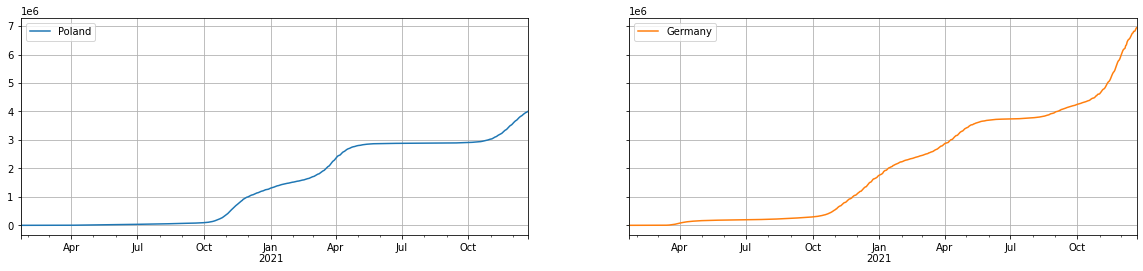

In [161]:
plot = compare_confirmed.plot(subplots=True, layout=(1,2), sharey=True, sharex=True, grid=True, legend='upper left', figsize=(20,4))

plplot = plot[0,0]
plplot.legend(loc='upper left')

deplot = plot[0,1]
deplot.legend(loc='upper left')

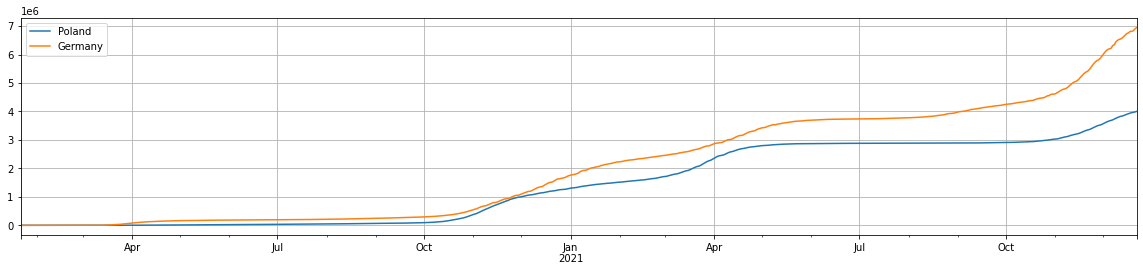

In [150]:
plot = compare_confirmed.plot(grid=True, legend='upper left', figsize=(20,4))

TypeError: unsupported operand type(s) for -: 'float' and 'AxesSubplot'

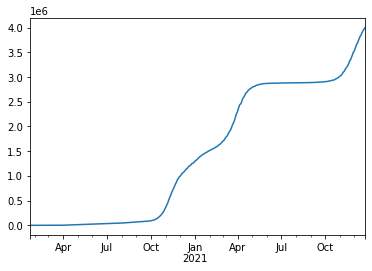

In [179]:
df - df.shift(periods=1, freq="D").plot()

In [190]:
df - df.shift(periods=1, freq="D")

2020-01-22        NaN
2020-01-23        0.0
2020-01-24        0.0
2020-01-25        0.0
2020-01-26        0.0
               ...   
2021-12-19    15976.0
2021-12-20     9610.0
2021-12-21    13807.0
2021-12-22    18013.0
2021-12-23        NaN
Length: 702, dtype: float64

In [191]:
df.diff()

2020-01-22        NaN
2020-01-23        0.0
2020-01-24        0.0
2020-01-25        0.0
2020-01-26        0.0
               ...   
2021-12-18    19392.0
2021-12-19    15976.0
2021-12-20     9610.0
2021-12-21    13807.0
2021-12-22    18013.0
Length: 701, dtype: float64

In [194]:
len(dir(pd))

142

In [195]:
len(dir(df))

419

## Timedelta

In [6]:
import sys
import pandas as pd
import numpy as np
import requests
from doctest import testmod as run_doctests

sys.tracebacklimit = 0


pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 50)

In [39]:
from datetime import datetime


SECOND = 1
MINUTE = 60 * SECOND
HOUR = 60 * MINUTE
DAY = 24 * HOUR
MONTH = 30.436875 * DAY  # Average days a month in solar calendar
YEAR = 365.2425 * DAY  # Solar calendar


def duration(td):
    years, seconds = divmod(td.total_seconds(), YEAR)
    months, seconds = divmod(seconds, MONTH)
    days, seconds = divmod(seconds, DAY)
    hours, seconds = divmod(td.seconds, HOUR)
    minutes, seconds = divmod(seconds, MINUTE)
    return {
        'years': int(years),
        'months': int(months),
        'days': int(days),
        'hours': int(hours),
        'minutes': int(minutes),
        'seconds': int(seconds)}


In [46]:
DATA = 'https://en.wikipedia.org/wiki/European_Astronaut_Corps'

current, former, *_ = pd.read_html(DATA)

in_space = current['Time in space'] == 'Currently in space'
current.loc[in_space, 'Time in space'] = pd.NaT

c = current['Time in space'].map(pd.to_timedelta).sum()
f = former['Time in space'].map(pd.to_timedelta).sum()

result = duration(c+f)
result = pd.DataFrame([result]).transpose()
result.columns = ['Total']

In [47]:
result

,Total
years,8
months,10
days,9
hours,23
minutes,46
seconds,0


## ESPN

In [3]:
import sys
import pandas as pd
import numpy as np
import requests
from doctest import testmod as run_doctests

sys.tracebacklimit = 0


pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 50)

ESPN = 'https://www.espn.com/nba/standings'
NBA = 'https://www.nba.com/standings'

espn = pd.read_html(ESPN)
nba = pd.read_html(NBA)

ValueError: No tables found

In [2]:
nba = pd.read_html(NBA)

ValueError: No tables found

In [1]:
import requests

In [23]:
response = requests.get(
    url = 'https://stats.nba.com/stats/leaguestandingsv3?LeagueID=00&Season=2021-22&SeasonType=Regular%20Season',
    headers = {
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/15.2 Safari/605.1.15',
        'Accept': 'application/json',
        'Referer': 'https://www.nba.com/',
        'X-MYHEADER': 'test123',
    },
)

data = response.json()
data = data['resultSets'][0]
name, header, rows = data.values()

result = []
for row in rows:
    row = zip(header, row)
    result.append(dict(row))
    
nba = pd.DataFrame(result)
nba

,LeagueID,SeasonID,TeamID,TeamCity,TeamName,TeamSlug,Conference,ConferenceRecord,PlayoffRank,ClinchIndicator,...,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,00,22021,1610612756,Phoenix,Suns,suns,West,16-5,1,,...,None,None,None,None,None,None,None,2-3,16-0,7-2
1,00,22021,1610612751,Brooklyn,Nets,nets,East,17-6,1,,...,None,None,None,None,None,None,None,4-3,11-3,6-3
2,00,22021,1610612741,Chicago,Bulls,bulls,East,10-7,2,,...,None,None,None,None,None,None,None,5-1,9-7,5-2
3,00,22021,1610612744,Golden State,Warriors,warriors,West,13-3,2,,...,None,None,None,None,None,None,None,5-1,13-2,7-3
4,00,22021,1610612749,Milwaukee,Bucks,bucks,East,14-9,3,,...,None,None,None,None,None,None,None,3-4,10-4,7-5
5,00,22021,1610612762,Utah,Jazz,jazz,West,11-3,3,,...,None,None,None,None,None,None,None,5-1,9-6,7-2
6,00,22021,1610612739,Cleveland,Cavaliers,cavaliers,East,12-7,4,,...,None,None,None,None,None,None,None,3-4,8-6,8-3
7,00,22021,1610612763,Memphis,Grizzlies,grizzlies,West,15-8,4,,...,None,None,None,None,None,None,None,3-3,8-7,8-3
8,00,22021,1610612746,LA,Clippers,clippers,West,12-13,5,,...,None,None,None,None,None,None,None,1-4,10-6,6-5
9,00,22021,1610612748,Miami,Heat,heat,East,13-7,5,,...,None,None,None,None,None,None,None,5-1,8-7,6-5
